In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator
from numpy import array

# Data Loading

In [2]:
filename='ETPercentile'

In [3]:
dataset= pd.read_csv(filename + ".csv")
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [4]:
gluon_dataset_copy

ds   y
0    2021-02-12 12:02:55.395  37
1    2021-02-12 12:03:25.262  37
2    2021-02-12 12:03:55.252  37
3    2021-02-12 12:04:25.244  37
4    2021-02-12 12:04:55.250  38
...                      ...  ..
2178 2021-02-13 06:11:55.316  72
2179 2021-02-13 06:12:25.309  72
2180 2021-02-13 06:12:55.314  72
2181 2021-02-13 06:13:25.314  54
2182 2021-02-13 06:13:55.343  39

[2183 rows x 2 columns]

In [5]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Splitting Data into Training and Testing

In [6]:
gluon_dataset_copy=gluon_dataset_copy.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-13 17:00:00"
train_time = "2021-02-13 21:00:00"
test_time = "2021-02-14 00:24:55"
freq='1min'

In [8]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )


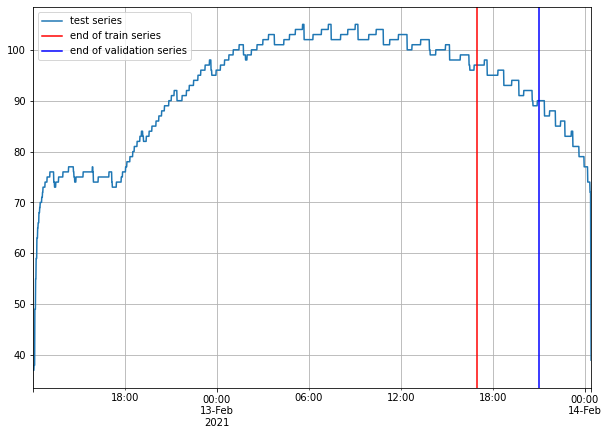

In [9]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()



test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [10]:
prediction_length

205

# Hyper-parameter Tuning

In [11]:
batch_size = [75,100]
epochs = [5,10]
num_batches_per_epoch = [10,20]
learning_rate = [1e-3,1e-4]

In [12]:
from sklearn.model_selection import ParameterGrid

param_grid = {#'num_hidden_dimensions':num_hidden_dimensions,
              'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 32


In [13]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = DeepAREstimator(
                        #num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    #agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


            MSE    abs_error  abs_target_sum  abs_target_mean  seasonal_error  \
0     20.847073   725.955688         19095.0        93.146341          0.0886   
1      4.447710   319.791199         19095.0        93.146341          0.0886   
2   1727.133994  5380.977539         19095.0        93.146341          0.0886   
3    757.651677  2130.094727         19095.0        93.146341          0.0886   
4      5.291612   377.367432         19095.0        93.146341          0.0886   
5     47.532827  1374.940186         19095.0        93.146341          0.0886   
6    112.098037  2143.179688         19095.0        93.146341          0.0886   
7    244.953811  2712.902344         19095.0        93.146341          0.0886   
8      7.626791   471.096252         19095.0        93.146341          0.0886   
9      5.892631   395.498810         19095.0        93.146341          0.0886   
10   109.636576  1811.064941         19095.0        93.146341          0.0886   
11   603.090091  3326.489746

# Forecast and Evaluation

In [14]:
estimator = DeepAREstimator(
    #num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)

In [15]:
predictor = estimator.train(train_ds)

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 20/20 [00:07<00:00,  2.83it/s, epoch=10/10, avg_epoch_loss=2.61]


# Save the Model

In [16]:
from pathlib import Path
predictor.serialize(Path("Models/NoTransformation"))

# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("Models/CubeRoot"))
# print(predictor_deserialized)

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



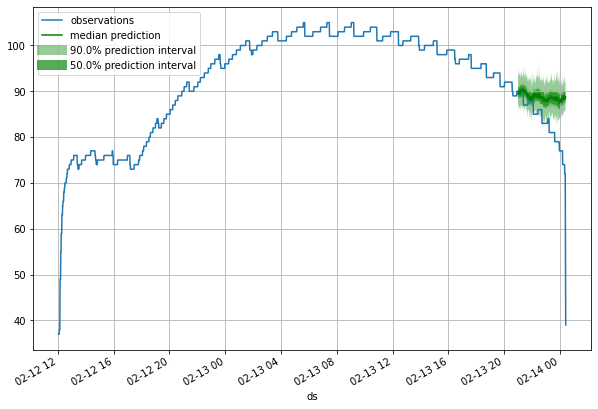

In [18]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(ts_entry)
    prediction_intervals = (50.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry)

In [19]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter([forecast_entry]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


In [20]:
agg_metrics

{'MSE': 61.85857945884146,
 'abs_error': 1147.8720703125,
 'abs_target_sum': 17062.0,
 'abs_target_mean': 83.22926829268293,
 'seasonal_error': 0.08750632271117856,
 'MASE': 63.98824426921789,
 'MAPE': 0.0743096993432268,
 'sMAPE': 0.06774447920527835,
 'OWA': nan,
 'MSIS': 1033.570676139768,
 'QuantileLoss[0.1]': 1247.5306747436525,
 'Coverage[0.1]': 0.697560975609756,
 'QuantileLoss[0.5]': 1147.8720092773438,
 'Coverage[0.5]': 0.9414634146341463,
 'QuantileLoss[0.9]': 341.82349853515615,
 'Coverage[0.9]': 1.0,
 'RMSE': 7.865022533905511,
 'NRMSE': 0.09449827801257939,
 'ND': 0.06727652504468995,
 'wQuantileLoss[0.1]': 0.07311749353790016,
 'wQuantileLoss[0.5]': 0.06727652146743311,
 'wQuantileLoss[0.9]': 0.020034198718506396,
 'mean_absolute_QuantileLoss': 912.4087275187175,
 'mean_wQuantileLoss': 0.05347607124127989,
 'MAE_Coverage': 0.3796747967479675}

# Residual

In [21]:
#get the mean for all the samples
f1 = forecast_entry_val.samples.mean(axis=0)
f2 = forecast_entry.samples.mean(axis=0)

In [22]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [23]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


Text(0.5, 1.0, 'Residuals')

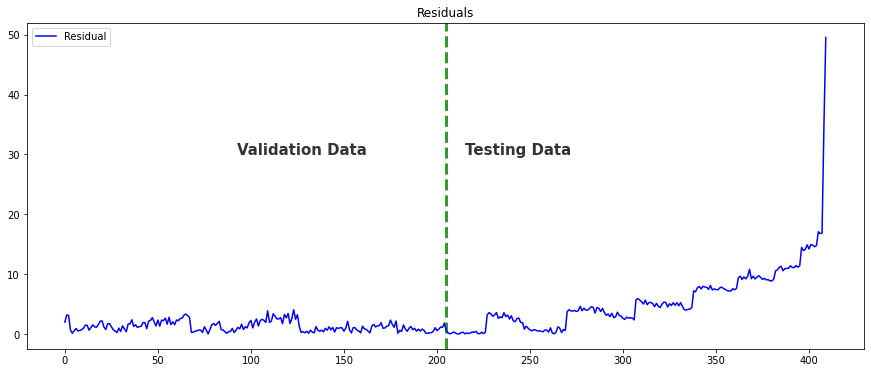

In [24]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=30, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=30, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

# Save the Predictions 

In [26]:
predictions_df=pd.DataFrame()
predictions_df['original'] = valandtest_orig
predictions_df['predictions'] = valandtest_pred
predictions_df.to_csv(Path("Predictions/NoTransformation.csv"),index=False)